# Method and Result 

Using an appropriately tuned deep feed-forward neural network to train the data ($2000$ training examples, with each example consisting of a time series/trajectory for the $x$-coordinate of 102 steps), we found that accuracy on the test data ($1000$ test examples, with each example consisting of a trajectory for the $x$-coordinate of 102 steps) is around $77 \%$ (a significant improvement over the accuracy of a random baseline). The accuracy rate could be further improved by using, for instance, more training data, including the trajectory for the $y$-coordinate in the training data set, or a more sophisticated neural network architecture. 

In [591]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
#plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [592]:
# First, we get the data
dataset0 = pd.read_csv("/Users/soonhoe/Desktop/AAA Python/trajx_m0.csv",header=None)
dataset1 = pd.read_csv("/Users/soonhoe/Desktop/AAA Python/trajx_m1.csv",header=None)
dataset2 = pd.read_csv("/Users/soonhoe/Desktop/AAA Python/trajx_m2.csv",header=None)

li = []
li.append(dataset0)
li.append(dataset1)
li.append(dataset2)

dataset = np.array(pd.concat(li, axis=0, ignore_index=True))
np.random.shuffle(dataset)
dataset = pd.DataFrame(dataset)

np.savetxt('all_traj.csv', np.c_[dataset], delimiter=',') 

dataset.head(10)
row=np.shape(dataset)[0]
col=np.shape(dataset)[1]
print(row); print(col)

3000
102


In [593]:
# Checking for missing values
num_train = int(row*2/3)
training_set = dataset[:num_train].iloc[:,0:col].values
test_set = dataset[num_train:].iloc[:,0:col].values
print(np.shape(training_set)); print(np.shape(test_set))

(2000, 102)
(1000, 102)


In [594]:
training_df = pd.DataFrame(training_set)
training_df.head(10)

#pd.plotting.scatter_matrix(training_df, c=training_set['750'], figsize=(15,15), marker='o', s=60)
#plt.show()

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,100,101
0,0.0,-0.008112,-0.007560,-0.004491,-0.036412,-0.054547,-0.058271,-0.063641,-0.080891,-0.076679,...,-0.496025,-0.478685,-0.501630,-0.511632,-0.513563,-0.527046,-0.509612,-0.514935,-0.531241,1.0
1,0.0,0.001431,0.006314,0.000071,-0.010614,-0.016995,-0.033122,-0.075458,-0.088546,-0.110400,...,-0.389688,-0.378837,-0.390090,-0.366439,-0.368462,-0.367142,-0.366486,-0.399945,-0.385635,1.0
2,0.0,-0.005832,-0.014218,0.009856,0.009080,0.009145,0.003475,-0.014983,-0.021645,-0.021933,...,0.179858,0.172982,0.167911,0.171535,0.148475,0.134451,0.119498,0.122040,0.107765,2.0
3,0.0,-0.025367,-0.029277,-0.015769,-0.031835,-0.037794,-0.038581,-0.032850,-0.031531,-0.025551,...,-0.520201,-0.542546,-0.528929,-0.533476,-0.530742,-0.532826,-0.546026,-0.579208,-0.609824,2.0
4,0.0,-0.015284,-0.024569,-0.020933,-0.014208,0.011406,0.010233,-0.008785,-0.013706,0.014585,...,-0.475318,-0.482259,-0.498864,-0.514436,-0.515569,-0.534107,-0.537033,-0.540476,-0.530733,2.0
5,0.0,0.005596,-0.004999,-0.019461,-0.021444,-0.034118,-0.057695,-0.062441,-0.064673,-0.079475,...,-0.408875,-0.401754,-0.413367,-0.419506,-0.407817,-0.442742,-0.446983,-0.491275,-0.513882,2.0
6,0.0,-0.012345,-0.034076,-0.044309,-0.028916,-0.016485,-0.016571,0.002102,0.012238,-0.013393,...,-0.002833,-0.013922,-0.014535,-0.003871,-0.031532,-0.028319,-0.033787,-0.013261,-0.020986,2.0
7,0.0,0.001046,-0.012549,-0.007477,-0.016921,-0.010790,-0.024641,-0.016604,-0.014605,-0.031147,...,0.021434,0.033390,0.026988,0.031465,0.008578,0.002180,-0.007462,0.003261,-0.009042,0.0
8,0.0,-0.030196,-0.040763,-0.045251,-0.062796,-0.064600,-0.049705,-0.084959,-0.123545,-0.122448,...,-0.531611,-0.538016,-0.529875,-0.545023,-0.553975,-0.566684,-0.564694,-0.558005,-0.575355,2.0
9,0.0,-0.001540,0.027802,0.044385,0.044554,0.038671,0.038163,0.044501,0.025458,-0.006539,...,-0.468212,-0.499556,-0.509951,-0.523403,-0.518249,-0.531277,-0.522842,-0.541226,-0.554423,1.0


In [599]:
#accuracy of a random baseline
import copy
y_test_copy=copy.copy(y_test)
np.random.shuffle(y_test_copy)
float(np.sum(np.array(y_test)==np.array(y_test_copy)))/len(y_test)

0.338

In [587]:
from __future__ import print_function

import keras
#from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop

#hyperparameters
batch_size = 500
epochs = 800

#number of categories
num_classes = 3

# the data, split between train and test sets
x_train=training_set[:,:col-1]
y_train=training_set[:,col-1:]
x_test=test_set[:,:col-1]
y_test=test_set[:,col-1:]

x_train = x_train.reshape(num_train, col-1)
x_test = x_test.reshape(row-num_train, col-1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
#x_train /= 255
#x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(np.shape(x_train)); print(np.shape(x_test))
print(np.shape(y_train)); print(np.shape(y_test))

2000 train samples
1000 test samples
(2000, 101)
(1000, 101)
(2000, 1)
(1000, 1)


In [567]:
# convert class vectors to class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Dense(64*2, activation='sigmoid', input_shape=(col-1,)))
model.add(Dropout(0.25))
model.add(Dense(64*2, activation='sigmoid'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_169 (Dense)            (None, 128)               13056     
_________________________________________________________________
dropout_46 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_170 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_47 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_171 (Dense)            (None, 3)                 387       
Total params: 29,955
Trainable params: 29,955
Non-trainable params: 0
_________________________________________________________________
Train on 2000 samples, validate on 1000 samples
Epoch 1/800
2000/2000 [==============================] - 5s 3ms/step - loss: 1.1615 - acc:

2000/2000 [==============================] - 0s 36us/step - loss: 0.6377 - acc: 0.6935 - val_loss: 0.5843 - val_acc: 0.7360
Epoch 54/800
2000/2000 [==============================] - 0s 41us/step - loss: 0.6357 - acc: 0.7015 - val_loss: 0.5866 - val_acc: 0.7390
Epoch 55/800
2000/2000 [==============================] - 0s 34us/step - loss: 0.6361 - acc: 0.7030 - val_loss: 0.5811 - val_acc: 0.7360
Epoch 56/800
2000/2000 [==============================] - 0s 28us/step - loss: 0.6396 - acc: 0.7100 - val_loss: 0.5920 - val_acc: 0.7410
Epoch 57/800
2000/2000 [==============================] - 0s 28us/step - loss: 0.6344 - acc: 0.7035 - val_loss: 0.5885 - val_acc: 0.7420
Epoch 58/800
2000/2000 [==============================] - 0s 28us/step - loss: 0.6358 - acc: 0.6985 - val_loss: 0.5913 - val_acc: 0.7410
Epoch 59/800
2000/2000 [==============================] - 0s 31us/step - loss: 0.6287 - acc: 0.7060 - val_loss: 0.5823 - val_acc: 0.7420
Epoch 60/800
2000/2000 [==============================

Epoch 113/800
2000/2000 [==============================] - 0s 28us/step - loss: 0.6112 - acc: 0.7140 - val_loss: 0.5788 - val_acc: 0.7440
Epoch 114/800
2000/2000 [==============================] - 0s 30us/step - loss: 0.6127 - acc: 0.7175 - val_loss: 0.5815 - val_acc: 0.7440
Epoch 115/800
2000/2000 [==============================] - 0s 30us/step - loss: 0.6195 - acc: 0.7095 - val_loss: 0.5743 - val_acc: 0.7370
Epoch 116/800
2000/2000 [==============================] - 0s 30us/step - loss: 0.6129 - acc: 0.7065 - val_loss: 0.5787 - val_acc: 0.7410
Epoch 117/800
2000/2000 [==============================] - 0s 31us/step - loss: 0.6092 - acc: 0.7180 - val_loss: 0.5782 - val_acc: 0.7400
Epoch 118/800
2000/2000 [==============================] - 0s 30us/step - loss: 0.6116 - acc: 0.7175 - val_loss: 0.5759 - val_acc: 0.7400
Epoch 119/800
2000/2000 [==============================] - 0s 30us/step - loss: 0.6113 - acc: 0.7165 - val_loss: 0.5780 - val_acc: 0.7440
Epoch 120/800
2000/2000 [=========

2000/2000 [==============================] - 0s 33us/step - loss: 0.6080 - acc: 0.7105 - val_loss: 0.5715 - val_acc: 0.7370
Epoch 173/800
2000/2000 [==============================] - 0s 31us/step - loss: 0.6060 - acc: 0.7135 - val_loss: 0.5696 - val_acc: 0.7440
Epoch 174/800
2000/2000 [==============================] - 0s 29us/step - loss: 0.6035 - acc: 0.7200 - val_loss: 0.5718 - val_acc: 0.7360
Epoch 175/800
2000/2000 [==============================] - 0s 29us/step - loss: 0.6039 - acc: 0.7090 - val_loss: 0.5670 - val_acc: 0.7410
Epoch 176/800
2000/2000 [==============================] - 0s 32us/step - loss: 0.5974 - acc: 0.7195 - val_loss: 0.5712 - val_acc: 0.7440
Epoch 177/800
2000/2000 [==============================] - 0s 28us/step - loss: 0.6055 - acc: 0.7180 - val_loss: 0.5705 - val_acc: 0.7370
Epoch 178/800
2000/2000 [==============================] - 0s 32us/step - loss: 0.6029 - acc: 0.7160 - val_loss: 0.5681 - val_acc: 0.7330
Epoch 179/800
2000/2000 [=======================

2000/2000 [==============================] - 0s 32us/step - loss: 0.5826 - acc: 0.7265 - val_loss: 0.5508 - val_acc: 0.7410
Epoch 232/800
2000/2000 [==============================] - 0s 30us/step - loss: 0.5861 - acc: 0.7270 - val_loss: 0.5490 - val_acc: 0.7370
Epoch 233/800
2000/2000 [==============================] - 0s 28us/step - loss: 0.5815 - acc: 0.7240 - val_loss: 0.5486 - val_acc: 0.7460
Epoch 234/800
2000/2000 [==============================] - 0s 28us/step - loss: 0.5839 - acc: 0.7295 - val_loss: 0.5497 - val_acc: 0.7460
Epoch 235/800
2000/2000 [==============================] - 0s 29us/step - loss: 0.5756 - acc: 0.7325 - val_loss: 0.5475 - val_acc: 0.7370
Epoch 236/800
2000/2000 [==============================] - 0s 30us/step - loss: 0.5766 - acc: 0.7255 - val_loss: 0.5482 - val_acc: 0.7440
Epoch 237/800
2000/2000 [==============================] - 0s 29us/step - loss: 0.5848 - acc: 0.7340 - val_loss: 0.5451 - val_acc: 0.7360
Epoch 238/800
2000/2000 [=======================

2000/2000 [==============================] - 0s 31us/step - loss: 0.5724 - acc: 0.7300 - val_loss: 0.5255 - val_acc: 0.7610
Epoch 291/800
2000/2000 [==============================] - 0s 29us/step - loss: 0.5664 - acc: 0.7435 - val_loss: 0.5283 - val_acc: 0.7600
Epoch 292/800
2000/2000 [==============================] - 0s 29us/step - loss: 0.5655 - acc: 0.7460 - val_loss: 0.5260 - val_acc: 0.7560
Epoch 293/800
2000/2000 [==============================] - 0s 30us/step - loss: 0.5631 - acc: 0.7415 - val_loss: 0.5246 - val_acc: 0.7620
Epoch 294/800
2000/2000 [==============================] - 0s 28us/step - loss: 0.5593 - acc: 0.7470 - val_loss: 0.5305 - val_acc: 0.7580
Epoch 295/800
2000/2000 [==============================] - 0s 28us/step - loss: 0.5684 - acc: 0.7385 - val_loss: 0.5261 - val_acc: 0.7570
Epoch 296/800
2000/2000 [==============================] - 0s 29us/step - loss: 0.5549 - acc: 0.7515 - val_loss: 0.5262 - val_acc: 0.7600
Epoch 297/800
2000/2000 [=======================

2000/2000 [==============================] - 0s 32us/step - loss: 0.5476 - acc: 0.7530 - val_loss: 0.5163 - val_acc: 0.7650
Epoch 350/800
2000/2000 [==============================] - 0s 31us/step - loss: 0.5505 - acc: 0.7480 - val_loss: 0.5137 - val_acc: 0.7690
Epoch 351/800
2000/2000 [==============================] - 0s 30us/step - loss: 0.5495 - acc: 0.7465 - val_loss: 0.5157 - val_acc: 0.7630
Epoch 352/800
2000/2000 [==============================] - 0s 29us/step - loss: 0.5483 - acc: 0.7485 - val_loss: 0.5108 - val_acc: 0.7670
Epoch 353/800
2000/2000 [==============================] - 0s 27us/step - loss: 0.5553 - acc: 0.7475 - val_loss: 0.5155 - val_acc: 0.7680
Epoch 354/800
2000/2000 [==============================] - 0s 28us/step - loss: 0.5518 - acc: 0.7555 - val_loss: 0.5111 - val_acc: 0.7660
Epoch 355/800
2000/2000 [==============================] - 0s 28us/step - loss: 0.5480 - acc: 0.7535 - val_loss: 0.5106 - val_acc: 0.7710
Epoch 356/800
2000/2000 [=======================

2000/2000 [==============================] - 0s 30us/step - loss: 0.5427 - acc: 0.7480 - val_loss: 0.5078 - val_acc: 0.7720
Epoch 409/800
2000/2000 [==============================] - 0s 32us/step - loss: 0.5511 - acc: 0.7600 - val_loss: 0.5061 - val_acc: 0.7720
Epoch 410/800
2000/2000 [==============================] - 0s 31us/step - loss: 0.5412 - acc: 0.7635 - val_loss: 0.5039 - val_acc: 0.7720
Epoch 411/800
2000/2000 [==============================] - 0s 29us/step - loss: 0.5425 - acc: 0.7570 - val_loss: 0.5097 - val_acc: 0.7760
Epoch 412/800
2000/2000 [==============================] - 0s 31us/step - loss: 0.5524 - acc: 0.7615 - val_loss: 0.5038 - val_acc: 0.7750
Epoch 413/800
2000/2000 [==============================] - 0s 28us/step - loss: 0.5338 - acc: 0.7615 - val_loss: 0.5071 - val_acc: 0.7720
Epoch 414/800
2000/2000 [==============================] - 0s 29us/step - loss: 0.5552 - acc: 0.7520 - val_loss: 0.5038 - val_acc: 0.7730
Epoch 415/800
2000/2000 [=======================

2000/2000 [==============================] - 0s 32us/step - loss: 0.5341 - acc: 0.7590 - val_loss: 0.5037 - val_acc: 0.7650
Epoch 468/800
2000/2000 [==============================] - 0s 30us/step - loss: 0.5414 - acc: 0.7575 - val_loss: 0.4999 - val_acc: 0.7740
Epoch 469/800
2000/2000 [==============================] - 0s 31us/step - loss: 0.5362 - acc: 0.7610 - val_loss: 0.5004 - val_acc: 0.7750
Epoch 470/800
2000/2000 [==============================] - 0s 32us/step - loss: 0.5406 - acc: 0.7560 - val_loss: 0.5035 - val_acc: 0.7720
Epoch 471/800
2000/2000 [==============================] - 0s 29us/step - loss: 0.5432 - acc: 0.7535 - val_loss: 0.5006 - val_acc: 0.7720
Epoch 472/800
2000/2000 [==============================] - 0s 31us/step - loss: 0.5350 - acc: 0.7655 - val_loss: 0.5017 - val_acc: 0.7740
Epoch 473/800
2000/2000 [==============================] - 0s 28us/step - loss: 0.5375 - acc: 0.7595 - val_loss: 0.5030 - val_acc: 0.7780
Epoch 474/800
2000/2000 [=======================

2000/2000 [==============================] - 0s 30us/step - loss: 0.5413 - acc: 0.7600 - val_loss: 0.4962 - val_acc: 0.7730
Epoch 527/800
2000/2000 [==============================] - 0s 29us/step - loss: 0.5420 - acc: 0.7575 - val_loss: 0.4977 - val_acc: 0.7750
Epoch 528/800
2000/2000 [==============================] - 0s 31us/step - loss: 0.5386 - acc: 0.7560 - val_loss: 0.4956 - val_acc: 0.7720
Epoch 529/800
2000/2000 [==============================] - 0s 31us/step - loss: 0.5376 - acc: 0.7585 - val_loss: 0.4962 - val_acc: 0.7740
Epoch 530/800
2000/2000 [==============================] - 0s 27us/step - loss: 0.5346 - acc: 0.7665 - val_loss: 0.4944 - val_acc: 0.7730
Epoch 531/800
2000/2000 [==============================] - 0s 30us/step - loss: 0.5374 - acc: 0.7510 - val_loss: 0.4967 - val_acc: 0.7750
Epoch 532/800
2000/2000 [==============================] - 0s 28us/step - loss: 0.5351 - acc: 0.7570 - val_loss: 0.4987 - val_acc: 0.7740
Epoch 533/800
2000/2000 [=======================

2000/2000 [==============================] - 0s 29us/step - loss: 0.5253 - acc: 0.7650 - val_loss: 0.4952 - val_acc: 0.7730
Epoch 586/800
2000/2000 [==============================] - 0s 33us/step - loss: 0.5371 - acc: 0.7630 - val_loss: 0.4964 - val_acc: 0.7710
Epoch 587/800
2000/2000 [==============================] - 0s 29us/step - loss: 0.5343 - acc: 0.7545 - val_loss: 0.4954 - val_acc: 0.7700
Epoch 588/800
2000/2000 [==============================] - 0s 29us/step - loss: 0.5349 - acc: 0.7660 - val_loss: 0.4952 - val_acc: 0.7740
Epoch 589/800
2000/2000 [==============================] - ETA: 0s - loss: 0.5318 - acc: 0.744 - 0s 28us/step - loss: 0.5312 - acc: 0.7580 - val_loss: 0.4941 - val_acc: 0.7750
Epoch 590/800
2000/2000 [==============================] - 0s 28us/step - loss: 0.5399 - acc: 0.7540 - val_loss: 0.4956 - val_acc: 0.7730
Epoch 591/800
2000/2000 [==============================] - 0s 27us/step - loss: 0.5273 - acc: 0.7690 - val_loss: 0.4945 - val_acc: 0.7710
Epoch 592/

2000/2000 [==============================] - 0s 29us/step - loss: 0.5339 - acc: 0.7560 - val_loss: 0.4966 - val_acc: 0.7750
Epoch 645/800
2000/2000 [==============================] - 0s 30us/step - loss: 0.5299 - acc: 0.7600 - val_loss: 0.4949 - val_acc: 0.7750
Epoch 646/800
2000/2000 [==============================] - 0s 33us/step - loss: 0.5341 - acc: 0.7610 - val_loss: 0.4937 - val_acc: 0.7720
Epoch 647/800
2000/2000 [==============================] - 0s 30us/step - loss: 0.5330 - acc: 0.7600 - val_loss: 0.4931 - val_acc: 0.7730
Epoch 648/800
2000/2000 [==============================] - 0s 27us/step - loss: 0.5219 - acc: 0.7685 - val_loss: 0.4933 - val_acc: 0.7760
Epoch 649/800
2000/2000 [==============================] - 0s 29us/step - loss: 0.5272 - acc: 0.7675 - val_loss: 0.4947 - val_acc: 0.7740
Epoch 650/800
2000/2000 [==============================] - 0s 29us/step - loss: 0.5299 - acc: 0.7655 - val_loss: 0.4976 - val_acc: 0.7760
Epoch 651/800
2000/2000 [=======================

2000/2000 [==============================] - 0s 34us/step - loss: 0.5291 - acc: 0.7580 - val_loss: 0.4939 - val_acc: 0.7720
Epoch 704/800
2000/2000 [==============================] - 0s 31us/step - loss: 0.5315 - acc: 0.7620 - val_loss: 0.4936 - val_acc: 0.7690
Epoch 705/800
2000/2000 [==============================] - 0s 30us/step - loss: 0.5329 - acc: 0.7570 - val_loss: 0.4931 - val_acc: 0.7710
Epoch 706/800
2000/2000 [==============================] - 0s 30us/step - loss: 0.5291 - acc: 0.7570 - val_loss: 0.4933 - val_acc: 0.7720
Epoch 707/800
2000/2000 [==============================] - 0s 30us/step - loss: 0.5295 - acc: 0.7620 - val_loss: 0.4930 - val_acc: 0.7700
Epoch 708/800
2000/2000 [==============================] - 0s 28us/step - loss: 0.5304 - acc: 0.7625 - val_loss: 0.4947 - val_acc: 0.7730
Epoch 709/800
2000/2000 [==============================] - 0s 35us/step - loss: 0.5259 - acc: 0.7665 - val_loss: 0.4932 - val_acc: 0.7750
Epoch 710/800
2000/2000 [=======================

2000/2000 [==============================] - 0s 31us/step - loss: 0.5240 - acc: 0.7610 - val_loss: 0.4907 - val_acc: 0.7710
Epoch 763/800
2000/2000 [==============================] - 0s 32us/step - loss: 0.5321 - acc: 0.7575 - val_loss: 0.4936 - val_acc: 0.7730
Epoch 764/800
2000/2000 [==============================] - 0s 31us/step - loss: 0.5272 - acc: 0.7625 - val_loss: 0.4938 - val_acc: 0.7730
Epoch 765/800
2000/2000 [==============================] - 0s 29us/step - loss: 0.5263 - acc: 0.7630 - val_loss: 0.4930 - val_acc: 0.7720
Epoch 766/800
2000/2000 [==============================] - 0s 30us/step - loss: 0.5222 - acc: 0.7620 - val_loss: 0.4936 - val_acc: 0.7720
Epoch 767/800
2000/2000 [==============================] - 0s 28us/step - loss: 0.5238 - acc: 0.7635 - val_loss: 0.4927 - val_acc: 0.7720
Epoch 768/800
2000/2000 [==============================] - 0s 32us/step - loss: 0.5290 - acc: 0.7615 - val_loss: 0.4909 - val_acc: 0.7710
Epoch 769/800
2000/2000 [=======================

In [568]:
print(classes)
print(np.shape(classes)) #probability distribution for each of the 3 models

[[5.3492397e-01 1.2248373e-02 4.5282772e-01]
 [8.1894338e-01 3.4179486e-04 1.8071489e-01]
 [6.5504330e-01 2.6713951e-06 3.4495395e-01]
 ...
 [1.4068453e-04 6.9625175e-01 3.0360764e-01]
 [1.1654807e-11 5.6935307e-02 9.4306475e-01]
 [2.3892335e-06 7.3740596e-01 2.6259163e-01]]
(1000, 3)


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


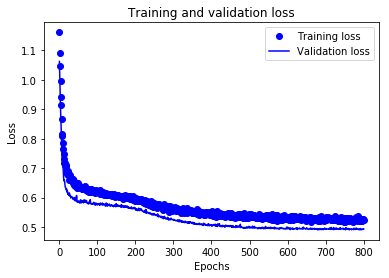

In [569]:
history_dict = history.history
print(history_dict.keys())
#plotting the training and validation loss
import matplotlib.pyplot as plt
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(acc)+1)
plt.plot(epochs,loss,'bo',label='Training loss') #bo for blue dot
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

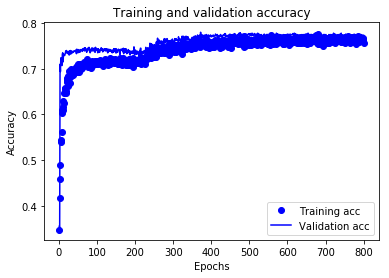

In [570]:
plt.clf()
acc=history_dict['acc']
val_acc=history_dict['val_acc']

plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'b',label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()